__Problem statement__: Develop a machine learning model to detect potentially fraudulent transactions based on the provided features. The dataset contains information about various transactions, including account age, payment method, time of transaction, and category. The goal is to build a classification model that can accurately classify transactions as either legitimate or potentially fraudulent.


__Data Dictionary__
- __AccountAgeDays:__ The local time at which the transaction was made. This can be used to analyze transaction patterns during different times of the day.

- __numItems:__ The number of items associated with the account.


- __LocalTime:__ The local time at which the transaction was made. This can be used to analyze transaction patterns during different times of the day.(ex: 4.745402 will be converted and understand as 4.44 AM) (timezone:24hrs)
- __PaymentMethod:__ The method used for payment (e.g., PayPal, store credit, credit card).
- __PaymentMethodAgeDays:__ The number of days since the payment method was associated with the account.(It indicates how long ago the current payment method (e.g., PayPal, credit card) was linked to the account.)
- the number of days since the payment method was first used by the user. This helps to determine the user's familiarity or trust with a specific payment method.

- __IsWeekend:__ A binary indicator of whether the transaction occurred on a weekend (1 for yes, 0 for no).
Category: The category of the transaction (e.g., electronics, shopping, food).
- __Label(Target column)__ A binary label (0 for legitimate, 1 for potentially fraudulent).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None
 
# to display the float values upto 6 decimal places     
pd.options.display.float_format = '{:.6f}'.format
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score,classification_report ,recall_score, f1_score, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'DS repeated_project25thMAy24.pptx',
 'Final_ppt.pptx',
 'Fraud_Detection.pptx',
 'Fraud_Detection_04-06.pptx',
 'fraud_detection_model.pkl',
 'Payment_Data.csv',
 'Project_Fraud_Detection.ipynb',
 'raw',
 '~$DS repeated_project25thMAy24.pptx']

In [3]:
# Load dataset
df = pd.read_csv('Payment_Data.csv')

In [4]:
df_raw = df.copy

In [5]:
df.shape

(39221, 8)

In [6]:
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.000000,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.000000,0
2,845,1,4.921318,creditcard,0.000000,food,1.000000,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.000000,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.000000,0


In [7]:
# Summary statistics
df.describe()

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,isWeekend,label
count,39221.000000,39221.000000,39221.000000,39221.000000,38661.000000,39221.000000
mean,857.563984,1.084751,4.748232,122.641326,0.499547,0.014278
std,804.788212,0.566899,0.389360,283.569177,0.500006,0.118636
min,1.000000,1.000000,0.421214,0.000000,0.000000,0.000000
25%,72.000000,1.000000,4.742303,0.000000,0.000000,0.000000
50%,603.000000,1.000000,4.886641,0.012500,0.000000,0.000000
75%,1804.000000,1.000000,4.962055,87.510417,1.000000,0.000000
max,2000.000000,29.000000,5.040929,1999.580556,1.000000,1.000000


In [8]:
df.dtypes.value_counts()

int64      3
float64    3
object     2
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   Category              39126 non-null  object 
 6   isWeekend             38661 non-null  float64
 7   label                 39221 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.4+ MB


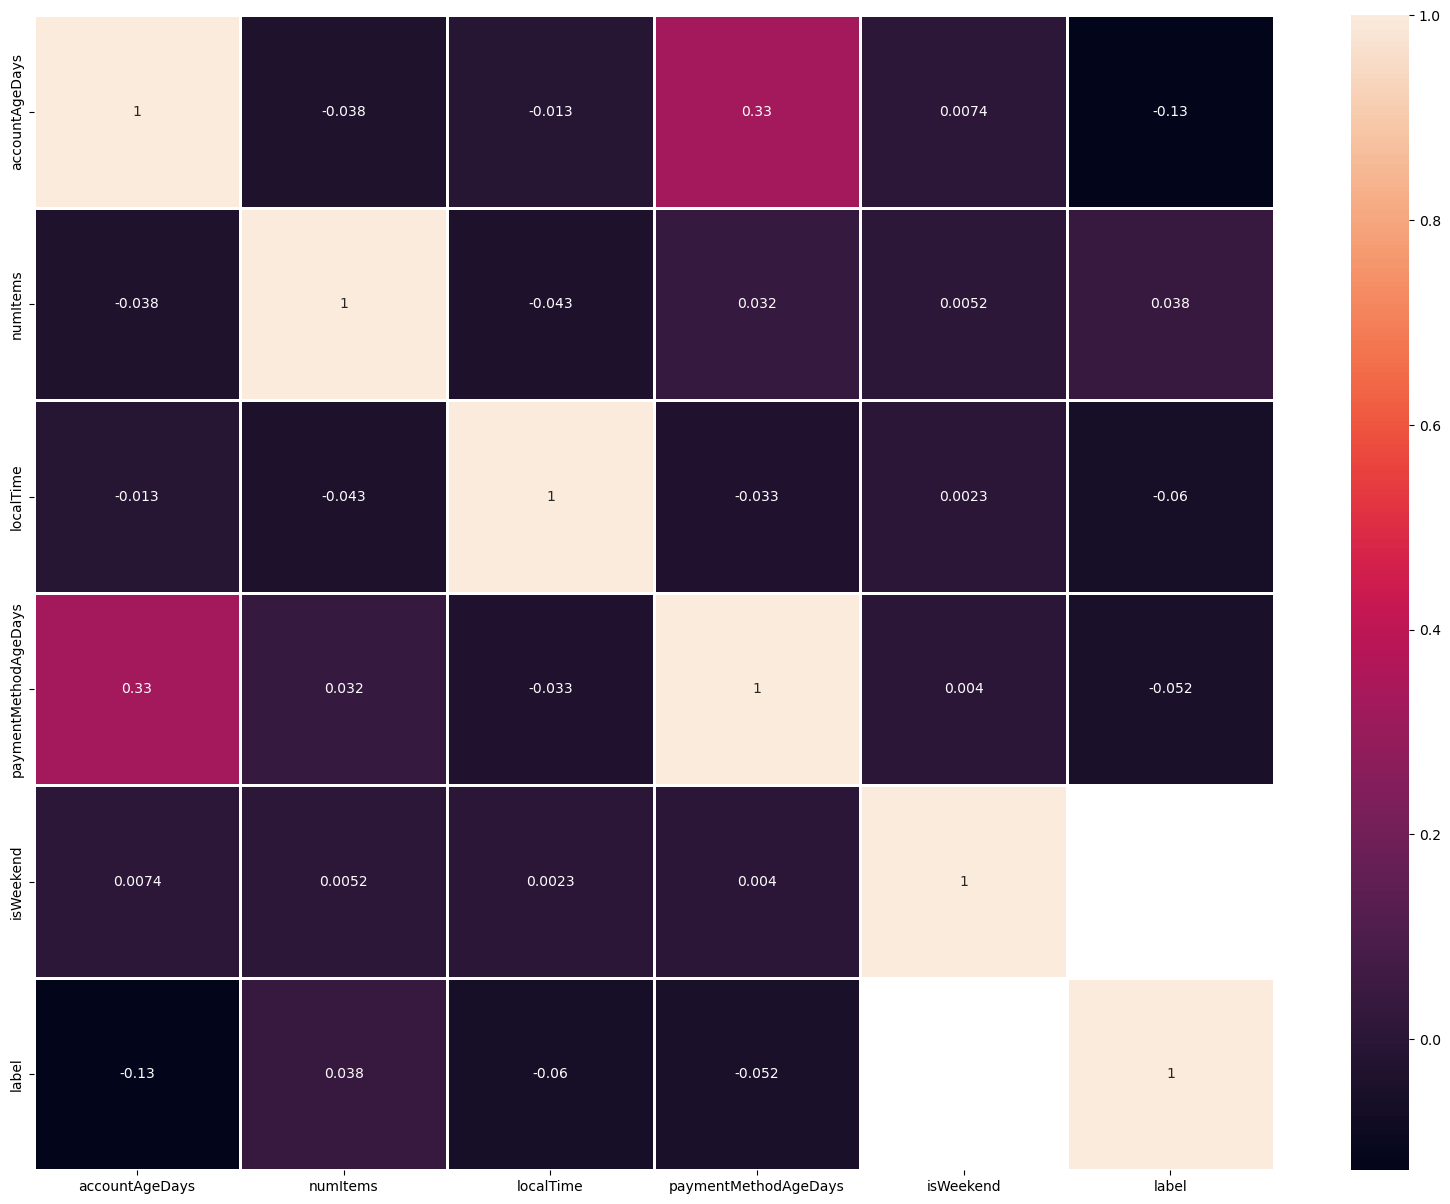

In [10]:
plt.figure(figsize = (20, 15))
sns.heatmap(data = df.corr(), annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [11]:
df.corr()['label'].abs().sort_values(ascending=False)

label                  1.000000
accountAgeDays         0.128098
localTime              0.059505
paymentMethodAgeDays   0.052047
numItems               0.038116
isWeekend                   NaN
Name: label, dtype: float64

__Finding__
- Even though isWeekend column seems to make no difference in learning of model as NaN correlation , this may not be the case when combined with other columns as the number of columns are less this column is being kept to see if in combination with others this makes difference

# Imbalanced target variable

In [12]:
# Imbalanced target variable
df['label'].value_counts()

0    38661
1      560
Name: label, dtype: int64

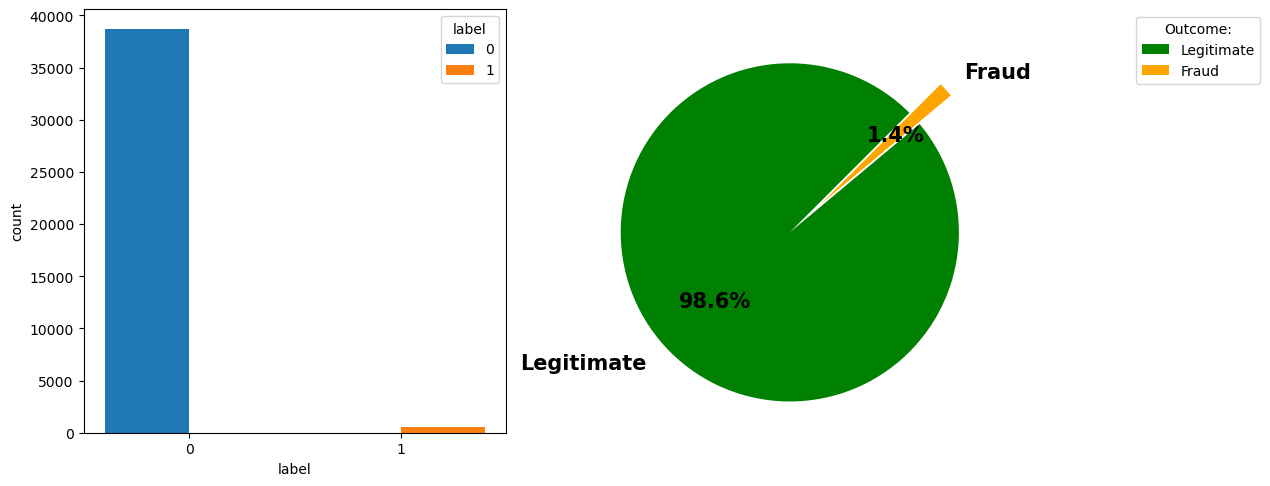

In [13]:
# Exploring target class

fig = plt.figure(figsize=(12,5.5))
ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(x=df['label'],data=df,saturation=1,hue='label')



ax2 = fig.add_subplot(1, 2, 2)        

plt.pie(df['label'].value_counts(),labels=['Legitimate','Fraud'],radius=1,colors = ['green','orange'],
        autopct='%1.1f%%',explode = [0.1,0.15],labeldistance=1.15,startangle = 45, 
        textprops={'fontsize': 15,'fontweight':'bold'})

plt.legend(title = 'Outcome:',loc='upper right', bbox_to_anchor=(1.6,1))
plt.show()

In [14]:
# Identify duplicates
duplicates = df[df.duplicated(keep=False)]
num_duplicates = duplicates.shape[0]
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 4229


In [15]:
# Analyze patterns in duplicates
print("\nDistribution of target variable in duplicates:")
print(duplicates['label'].value_counts())


Distribution of target variable in duplicates:
0    3971
1     258
Name: label, dtype: int64


In [16]:
df['label'].value_counts()

0    38661
1      560
Name: label, dtype: int64

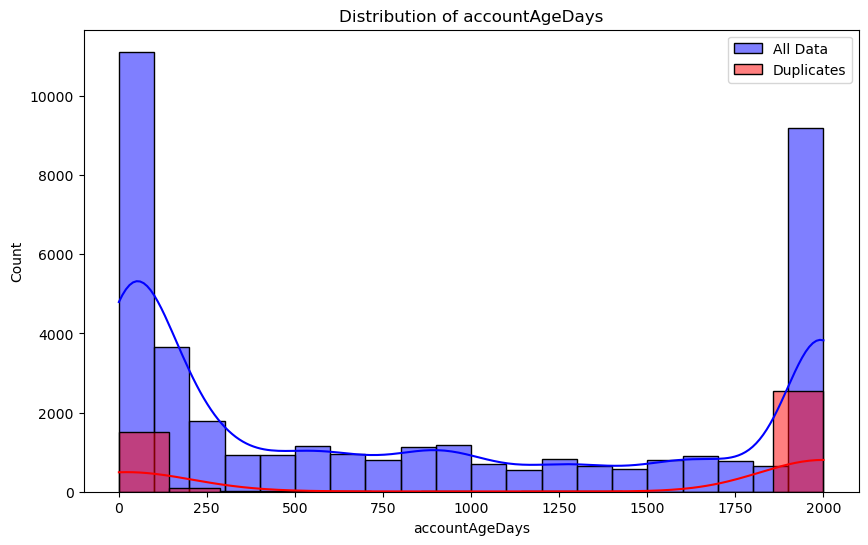

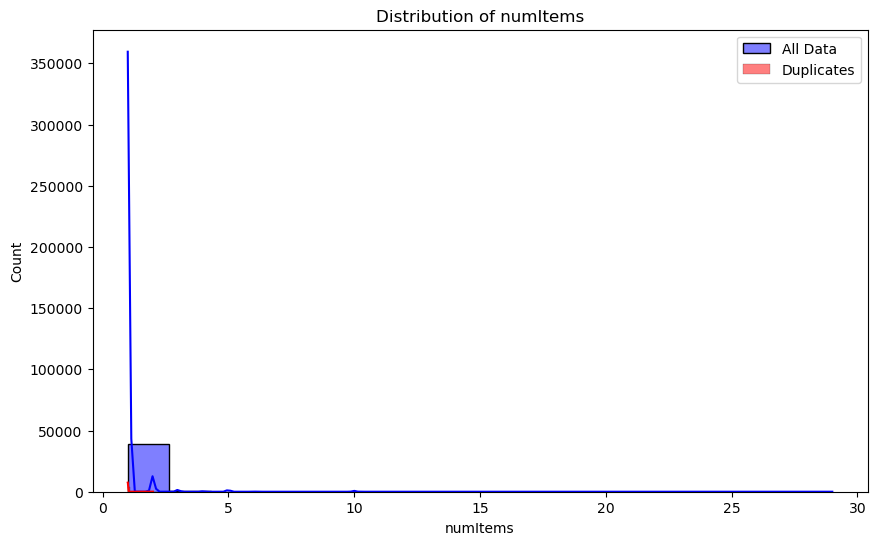

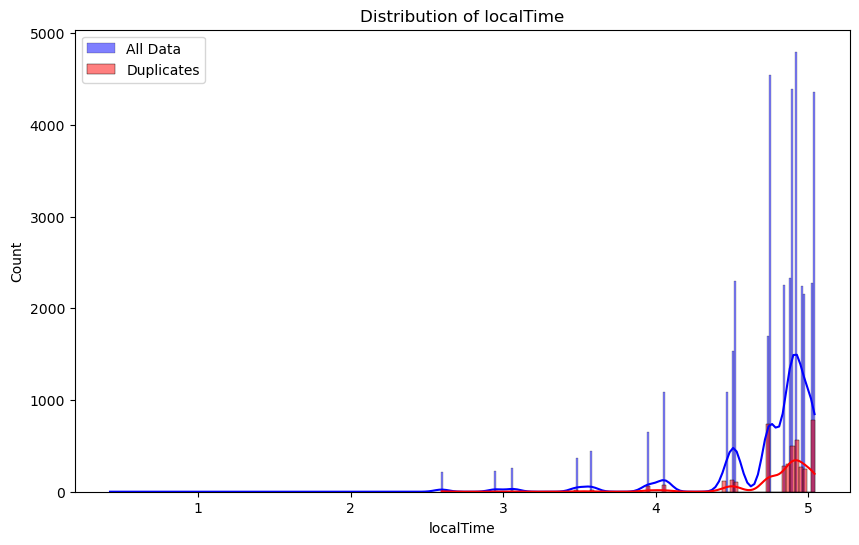

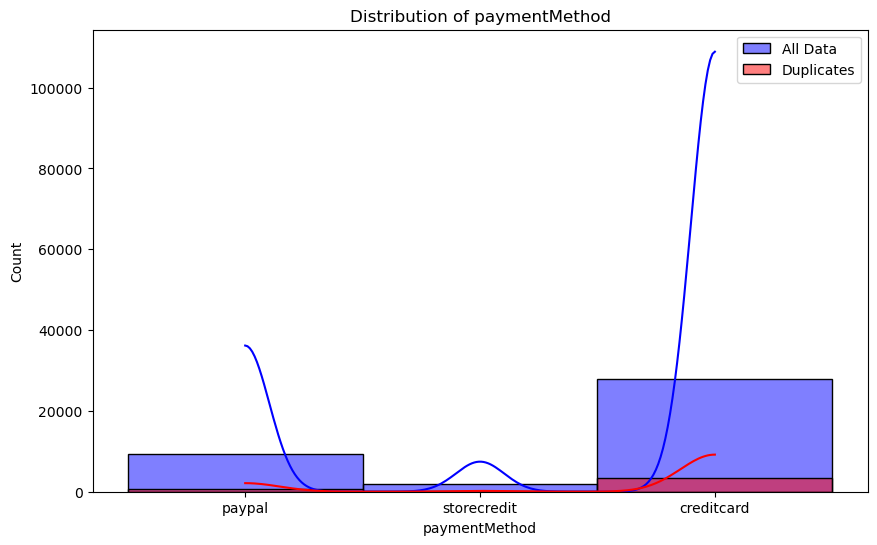

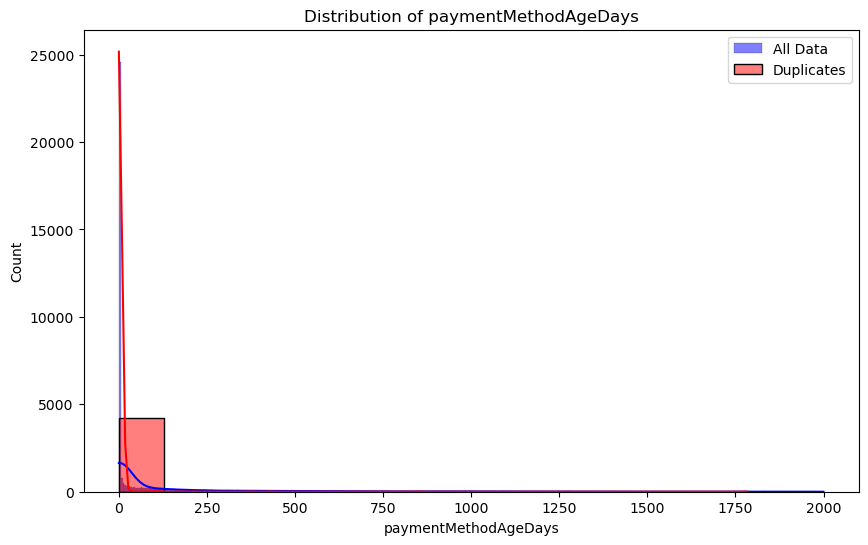

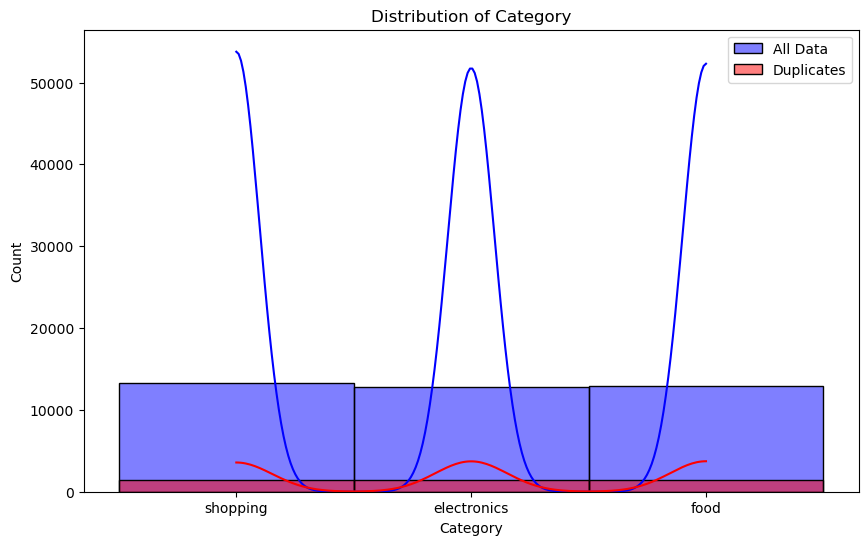

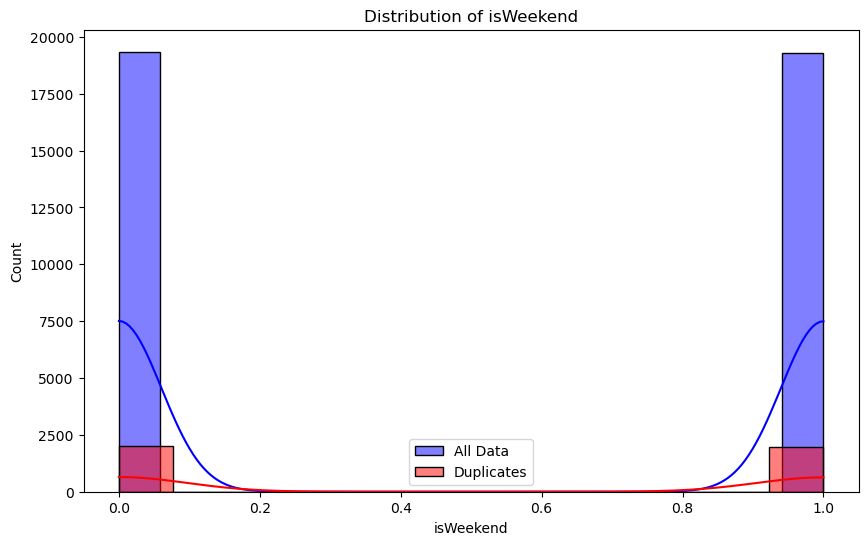

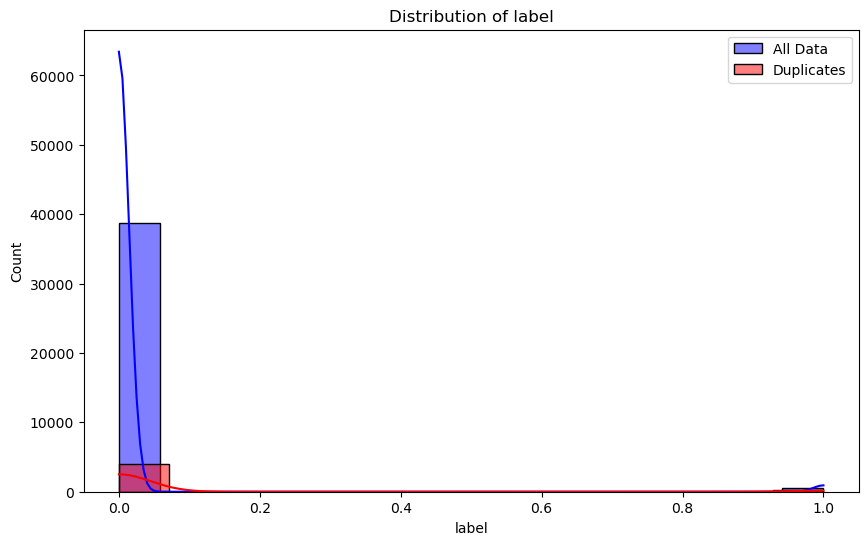

In [17]:
# Compare feature distributions between duplicates and non-duplicates
for column in df.columns:
    if column != 'Label':
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column], kde=True, label='All Data', color='blue')
        sns.histplot(duplicates[column], kde=True, label='Duplicates', color='red')
        plt.title(f'Distribution of {column}')
        plt.legend()
        plt.show()


In [18]:
# Summary statistics for duplicates
print("\nSummary statistics for duplicated rows:")
print(duplicates.describe(include='all'))


Summary statistics for duplicated rows:
        accountAgeDays    numItems   localTime paymentMethod  \
count      4229.000000 4229.000000 4229.000000          4229   
unique             NaN         NaN         NaN             3   
top                NaN         NaN         NaN    creditcard   
freq               NaN         NaN         NaN          3374   
mean       1226.303145    1.007330    4.814609           NaN   
std         956.798150    0.085313    0.292902           NaN   
min           1.000000    1.000000    2.596228           NaN   
25%          10.000000    1.000000    4.748314           NaN   
50%        2000.000000    1.000000    4.895263           NaN   
75%        2000.000000    1.000000    4.962055           NaN   
max        2000.000000    2.000000    5.040929           NaN   

        paymentMethodAgeDays Category   isWeekend       label  
count            4229.000000     4229 3971.000000 4229.000000  
unique                   NaN        3         NaN         NaN 

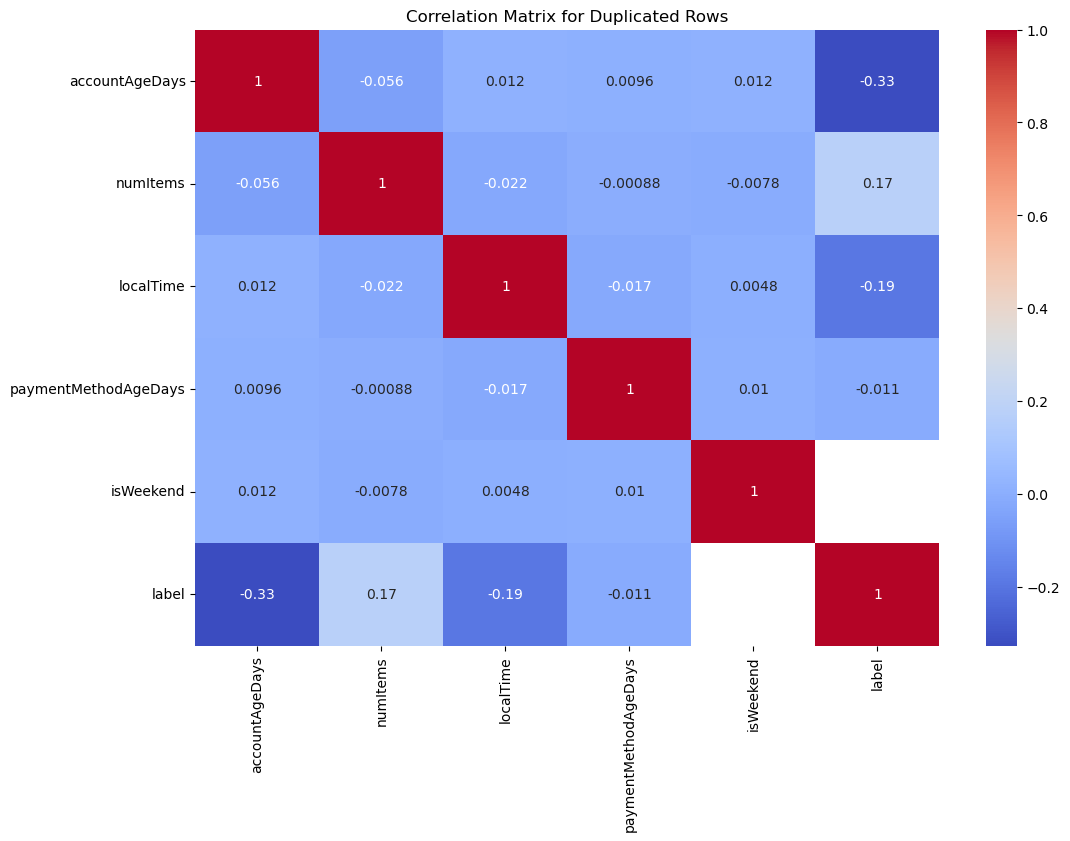

In [19]:
# Visualize correlation matrix for duplicated rows
plt.figure(figsize=(12, 8))
sns.heatmap(duplicates.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Duplicated Rows')
plt.show()

#  duplicates exhibit certain patterns, especially in relation to the target variable and some features. (So Duplicates can be retained for analysis )

In [20]:
# Assuming 'data' is your DataFrame containing the binary columns and target column
#,'isWeekend','Category'
binary_plus_columns = ['numItems','paymentMethod','Category']  # List of binary columns
target_column = 'label'  # Name of the target column


for column in binary_plus_columns:
    pivot_table = df.pivot_table(index=column, columns=target_column, aggfunc='size', fill_value=0)
    pivot_table['Total'] = pivot_table.sum(axis=1)
    pivot_table['% Fraud'] = pivot_table[1] / pivot_table['Total']
    pivot_table['% Legitimate'] = pivot_table[0] / pivot_table['Total']
#     print(f"\nPivot table for {column} vs {target_column}:\n")
#     print(pivot_table)
  
    pivot_table_styled = pivot_table.style.background_gradient(cmap='Blues', subset=['% Fraud', '% Legitimate']) \
                                      .set_caption(f'Pivot table for {column} vs {target_column}') \
                                      .format({'% Fraud': '{:.2%}', '% Legitimate': '{:.2%}'})
    display(pivot_table_styled)

label,0,1,Total,% Fraud,% Legitimate
numItems,,,,,
1,36944,454,37398,1.21%,98.79%
2,1266,82,1348,6.08%,93.92%
3,148,16,164,9.76%,90.24%
4,39,3,42,7.14%,92.86%
5,164,4,168,2.38%,97.62%
6,15,0,15,0.00%,100.00%
7,5,0,5,0.00%,100.00%
8,5,0,5,0.00%,100.00%
9,1,0,1,0.00%,100.00%


label,0,1,Total,% Fraud,% Legitimate
paymentMethod,,,,,
creditcard,27594,410,28004,1.46%,98.54%
paypal,9174,129,9303,1.39%,98.61%
storecredit,1893,21,1914,1.10%,98.90%


label,0,1,Total,% Fraud,% Legitimate
Category,,,,,
electronics,12658,176,12834,1.37%,98.63%
food,12787,177,12964,1.37%,98.63%
shopping,13129,199,13328,1.49%,98.51%


# Feature Engineering

In [21]:
# Create a new feature to flag numItems with higher fraud rates
df['HighFraudNumItems'] = df['numItems'].isin([2, 3, 4]).astype(int)

# Preprocessing

In [22]:
# Convert LocalTime to hour of the day
df['localTime'] = df['localTime'] % 24

In [23]:
def create_count_plot(data, x_col, hue_col, title):
    # Define the neon_palette
    neon_palette = ["#faeb2c", "#f52789", "#e900ff", "#1685f8", "#3d144c"]

    # Create the count plot
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=data, x=x_col, hue=hue_col, palette=neon_palette)
    ax.set_facecolor('#F6F5F4')
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    
    ax.grid(True, linestyle='--', alpha=0.5)
    sns.despine(right=True)
    sns.despine(offset=5, trim=True)

    # Adding percentage annotations
    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f}%'.format((height / total) * 100),
                ha="center", fontsize=10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    
    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Univariate

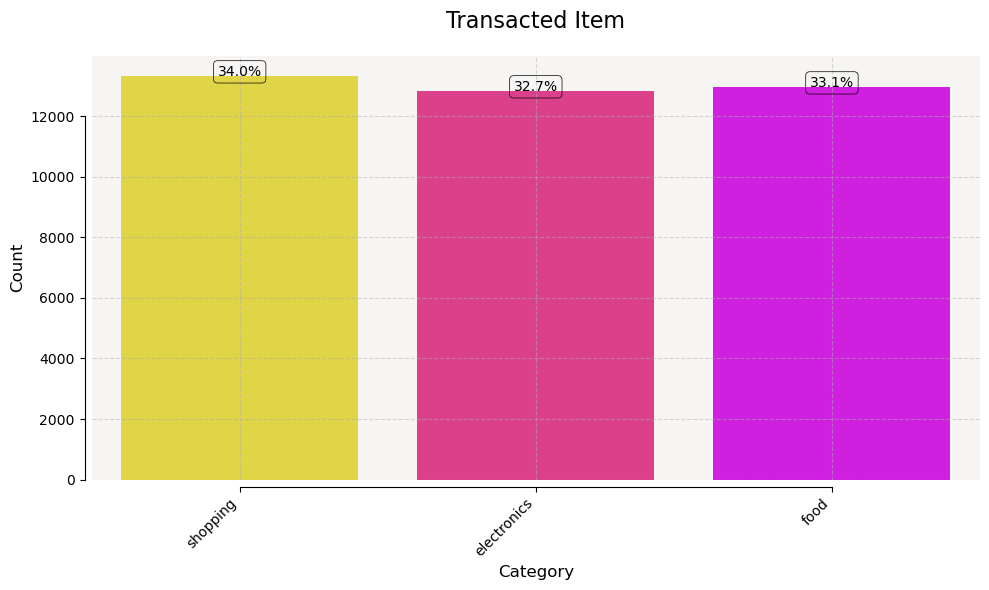

In [24]:
#Count plot for Transacted item
create_count_plot(df, x_col='Category', hue_col=None, title='Transacted Item')

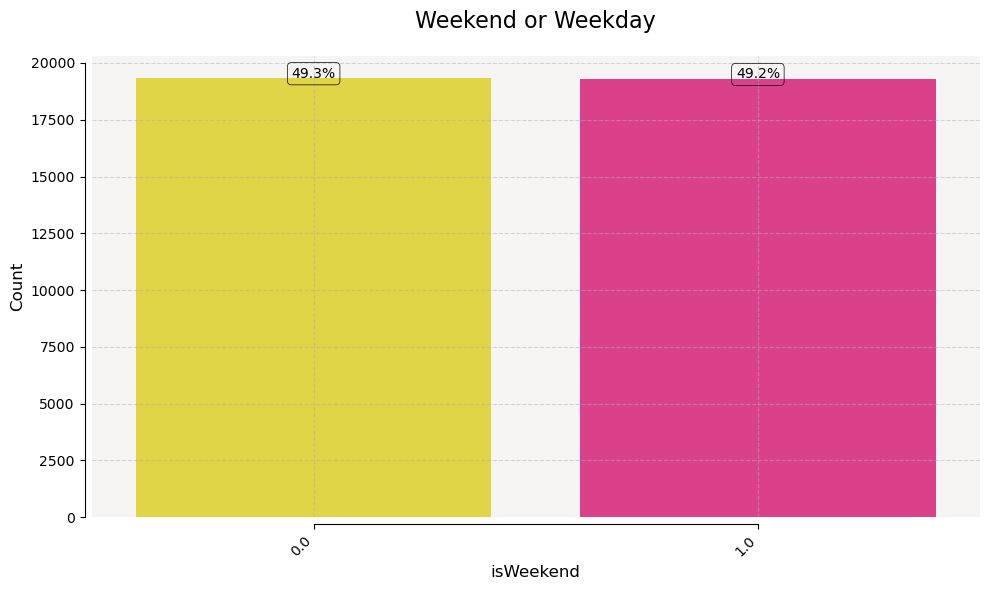

In [25]:
#Count plot for segment
create_count_plot(df, x_col='isWeekend', hue_col=None, title='Weekend or Weekday')

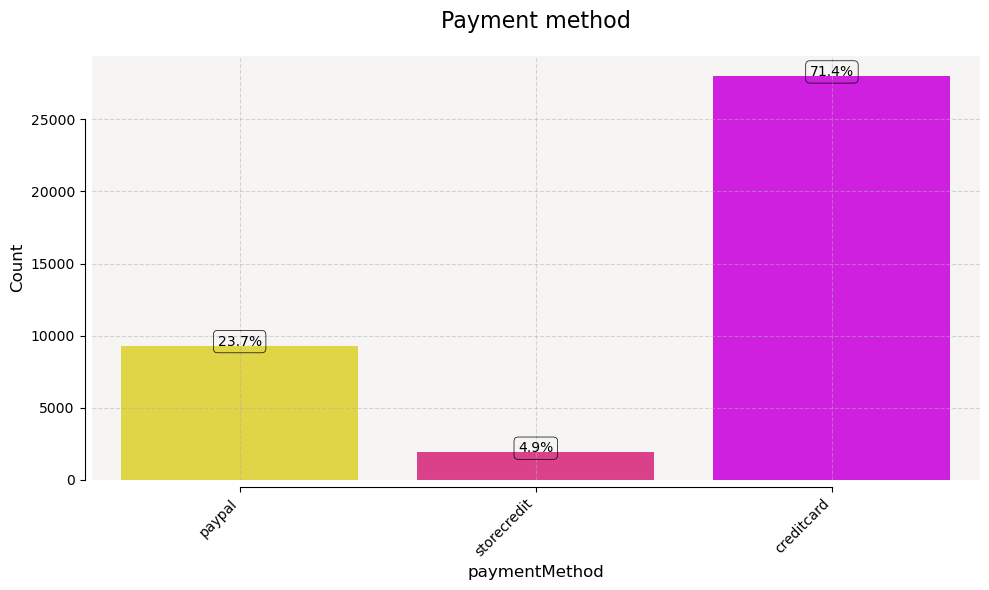

In [26]:
#Count plot for payment method
create_count_plot(df, x_col='paymentMethod', hue_col=None, title='Payment method')

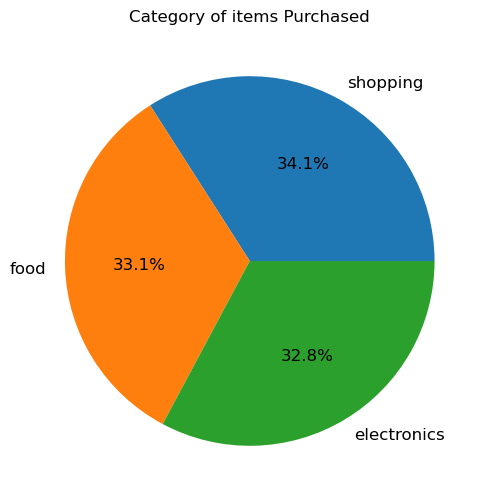

In [27]:
fig = plt.figure(figsize=(8, 6))

# Calculate the percentage of each Categopry item
Category = df['Category'].value_counts() * 100.0 / len(df)

# Plot the pie chart
ax = Category.plot.pie(autopct='%.1f%%', labels=Category.index,
                                      fontsize=12)

# Set title
ax.set_title('Category of items Purchased')

# Hide y-axis label
ax.set_ylabel('')

plt.show()

In [28]:
df = pd.get_dummies(df, columns=['paymentMethod'], drop_first=True)

# Missing Values

In [29]:
# Check for missing values
print(df.isnull().sum())

accountAgeDays                 0
numItems                       0
localTime                      0
paymentMethodAgeDays           0
Category                      95
isWeekend                    560
label                          0
HighFraudNumItems              0
paymentMethod_paypal           0
paymentMethod_storecredit      0
dtype: int64


# Outliers

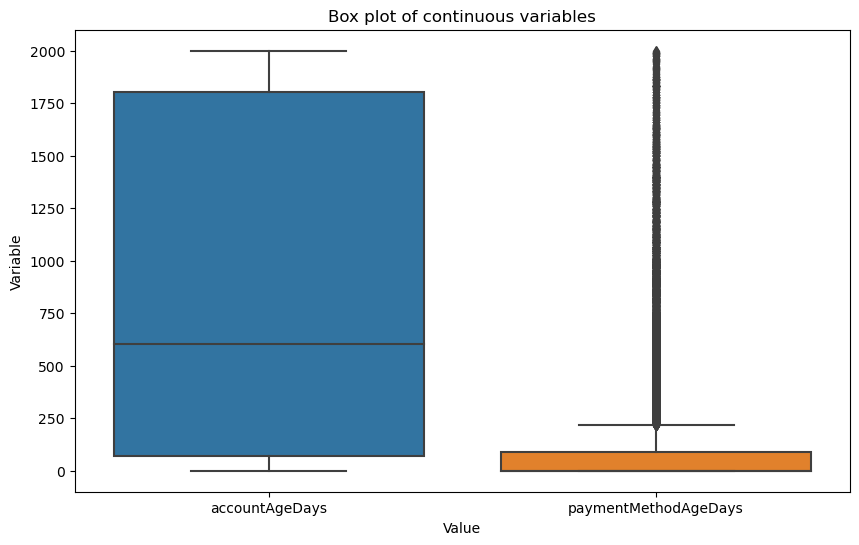

In [30]:
# Outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['accountAgeDays','paymentMethodAgeDays']])
plt.title('Box plot of continuous variables')
plt.xlabel('Value')
plt.ylabel('Value')
plt.ylabel('Variable')
plt.show()

In [31]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) and IQR
Q1 = df['paymentMethodAgeDays'].quantile(0.25)
Q3 = df['paymentMethodAgeDays'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
# outliers = df[(df['paymentMethodAgeDays'] < lower_bound) | (df['paymentMethodAgeDays'] > upper_bound)]
outliers = df[(df['paymentMethodAgeDays'] > upper_bound)]
print("Q1 (25th percentile):", Q1)
print("Q3 (75th percentile):", Q3)
print("IQR:", IQR)
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)
print("\nOutliers:")
print(len(outliers))

Q1 (25th percentile): 0.0
Q3 (75th percentile): 87.51041667
IQR: 87.51041667
Lower bound for outliers: -131.265625005
Upper bound for outliers: 218.776041675

Outliers:
6350


# Handling Missing Values

In [32]:
df['Category'].fillna(df['Category'].mode()[0], inplace=True)
df['isWeekend'].fillna(df['isWeekend'].mode()[0], inplace=True)

In [33]:
# Create dummy variables for Category
df = pd.get_dummies(df, columns=['Category'], drop_first=True)

#  Visualizations to check skewness and distribution

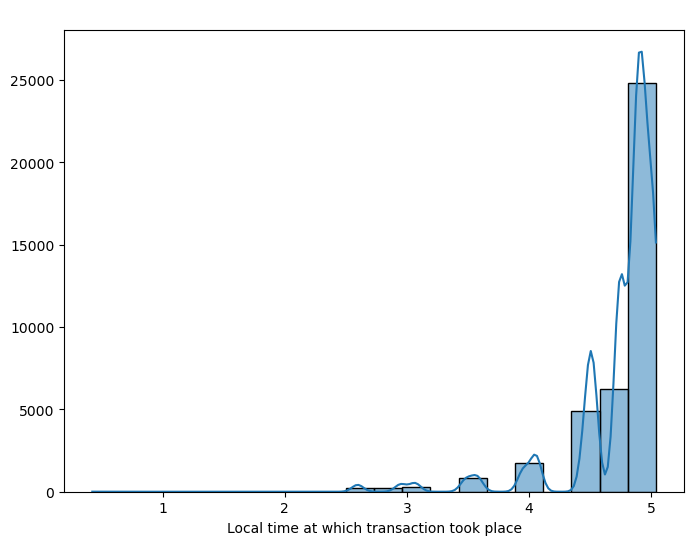

In [34]:
# Example: Histogram for a numerical variable
plt.figure(figsize=(8, 6))
sns.histplot(df['localTime'], bins=20, kde=True)
plt.title(' ')
plt.xlabel('Local time at which transaction took place')
plt.ylabel('')
plt.show()

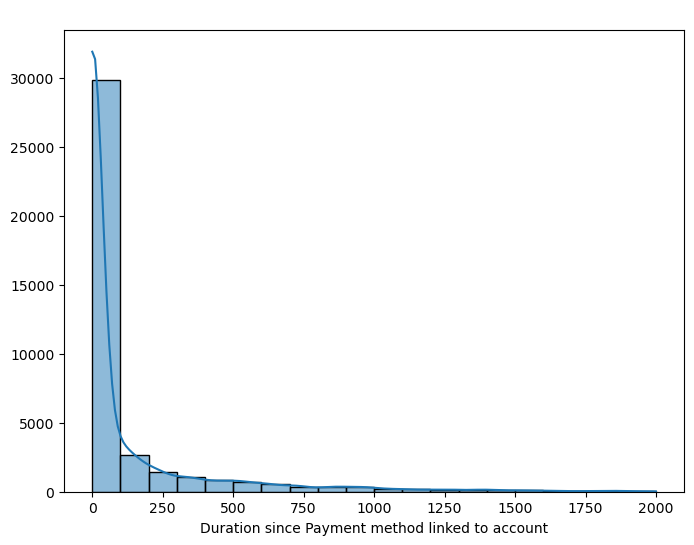

In [35]:
# Example: Histogram for a numerical variable
plt.figure(figsize=(8, 6))
sns.histplot(df['paymentMethodAgeDays'], bins=20, kde=True)
plt.title(' ')
plt.xlabel('Duration since Payment method linked to account')
plt.ylabel('')
plt.show()

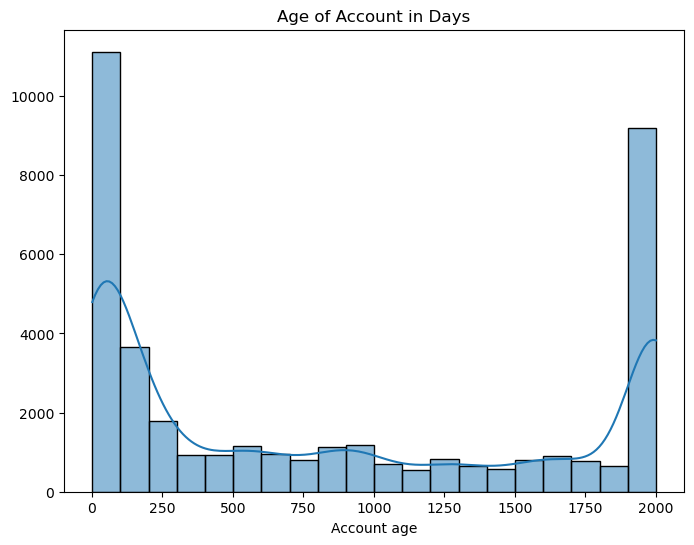

In [36]:
# Histogram for numerical data 
# Example: Histogram for a numerical variable
plt.figure(figsize=(8, 6))
sns.histplot(df['accountAgeDays'], bins=20, kde=True)
plt.title('Age of Account in Days')
plt.xlabel('Account age')
plt.ylabel('')
plt.show()

# Transforming skewed data

In [37]:
# Transform LocalTime (Negatively Skewed)
pt = PowerTransformer(method='yeo-johnson')
df['Transformed_LocalTime'] = pt.fit_transform(df[['localTime']])

In [38]:
# Transform PaymentMethodAgeDays (Positively Skewed)
df['Log_PaymentMethodAgeDays'] = np.log1p(df['paymentMethodAgeDays'])

In [39]:
cat=df.select_dtypes(include=object).columns

In [40]:
num_col=df.select_dtypes(include=np.number).columns

# Checking outliers after Transformation

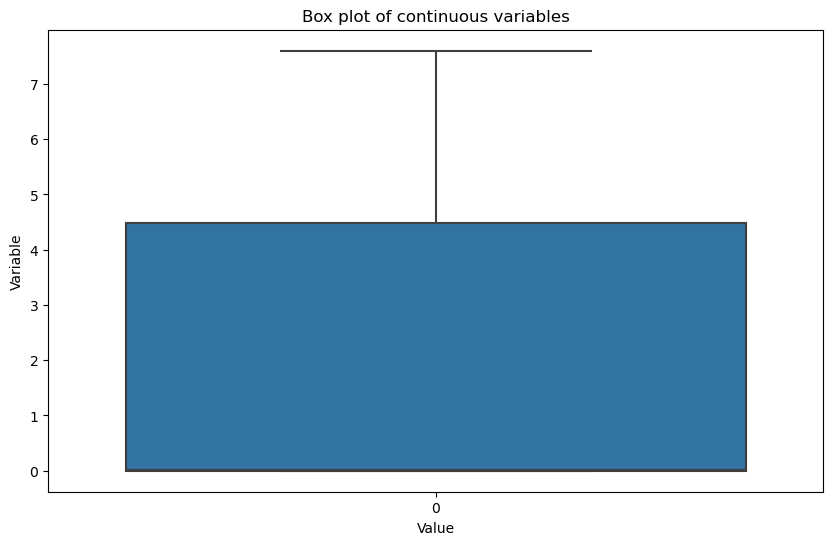

In [41]:
# Outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df['Log_PaymentMethodAgeDays'])
plt.title('Box plot of continuous variables')
plt.xlabel('Value')
plt.ylabel('Value')
plt.ylabel('Variable')
plt.show()

# Checking distribution after Transformation

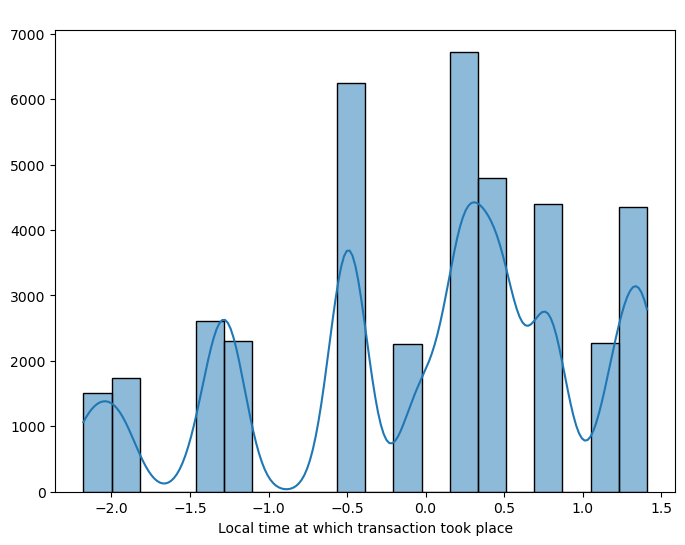

In [42]:
# Example: Histogram for a numerical variable
plt.figure(figsize=(8, 6))
sns.histplot(df['Transformed_LocalTime'], bins=20, kde=True)
plt.title(' ')
plt.xlabel('Local time at which transaction took place')
plt.ylabel('')
plt.show()

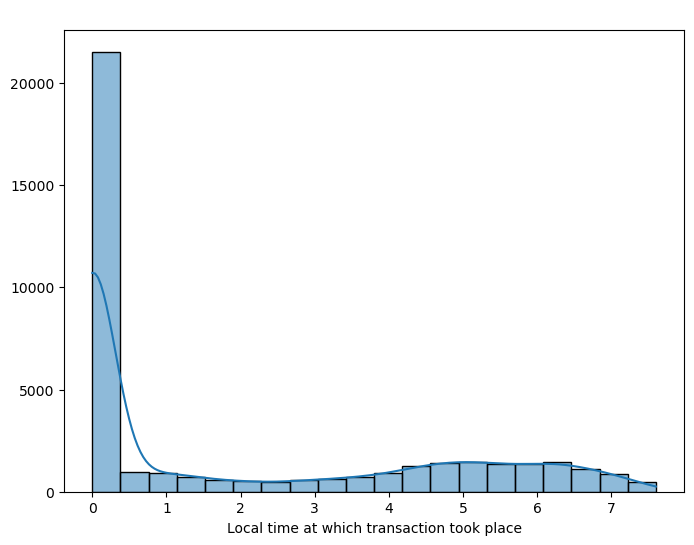

In [43]:
# Example: Histogram for a numerical variable
plt.figure(figsize=(8, 6))
sns.histplot(df['Log_PaymentMethodAgeDays'], bins=20, kde=True)
plt.title(' ')
plt.xlabel('Local time at which transaction took place')
plt.ylabel('')
plt.show()

# Observations
- __High Fraud num items__ contributing to learning more than num items ( both can be kept as providing seperate learning)
- Log __payment method age days__ contributing less than payment method age days so transformed column may be dropped

# Define features and target variable

In [44]:
# Define features and target variable
X = df.drop(['label','Log_PaymentMethodAgeDays','Transformed_LocalTime'], axis=1)
y = df['label']

# Split data into training and testing sets

In [45]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE on the training data

In [46]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=42,sampling_strategy=0.30)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

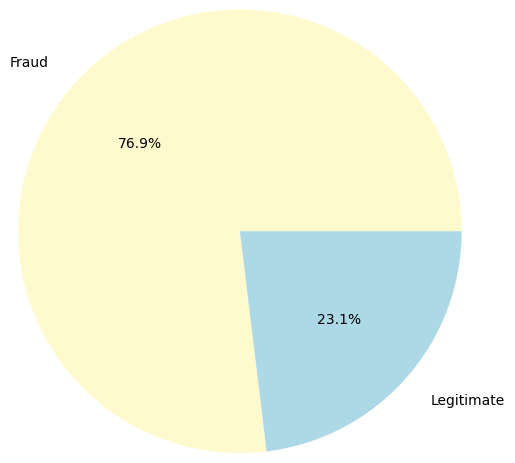

In [47]:
plt.pie(y_train_resampled.value_counts(),labels=['Fraud','Legitimate'],radius=1.5,colors = ['#FFFACD','#ADD8E6'],
        autopct='%1.1f%%',labeldistance=1.15,startangle =0)

plt.show()

# Define the numerical features to be standardized

In [48]:
numerical_features = ['localTime', 'paymentMethodAgeDays']

In [49]:
# Initialize the scaler
scaler = StandardScaler()

In [50]:
# Fit and transform the resampled training data
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])

In [51]:
# Apply the same scaler to the test data
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [52]:
# Model selection and training
log_reg = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
gb = GradientBoostingClassifier()

In [53]:
log_reg.fit(X_train_resampled, y_train_resampled)
rf.fit(X_train_resampled, y_train_resampled)
dt.fit(X_train_resampled, y_train_resampled)
gb.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier()

In [54]:
# Model evaluation
def evaluate_model(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Logistic Regression:")
evaluate_model(y_test, log_reg.predict(X_test))

print("Random Forest:")
evaluate_model(y_test, rf.predict(X_test))

print("Decision Tree:")
evaluate_model(y_test, dt.predict(X_test))

print("Gradient Boosting:")
evaluate_model(y_test, gb.predict(X_test))

Logistic Regression:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Confusion Matrix:
 [[7727    0]
 [   0  118]]
Random Forest:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Confusion Matrix:
 [[7727    0]
 [   0  118]]
Decision Tree:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Confusion Matrix:
 [[7727    0]
 [   0  118]]
Gradient Boosting:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Confusion Matrix:
 [[7727    0]
 [   0  118]]


## Training data accuracy check(Logistics Regression)

In [55]:
print("Logistic Regression:")
print(classification_report(y_train,log_reg.predict(X_train)))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30934
           1       1.00      1.00      1.00       442

    accuracy                           1.00     31376
   macro avg       1.00      1.00      1.00     31376
weighted avg       1.00      1.00      1.00     31376



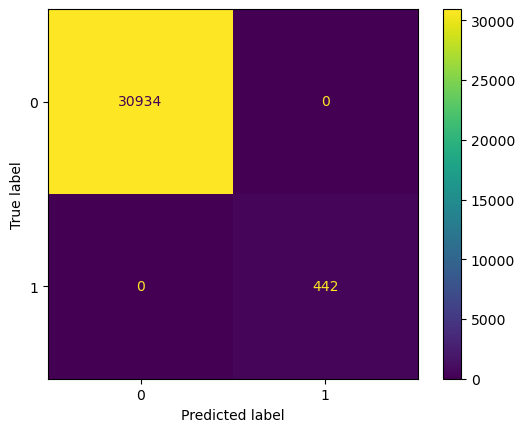

In [56]:
ConfusionMatrixDisplay.from_predictions(y_train,log_reg.predict(X_train))

# Logistics Regression Classification report(Testing data)

In [57]:
print("Logistic Regression:")
print(classification_report(y_test,log_reg.predict(X_test)))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7727
           1       1.00      1.00      1.00       118

    accuracy                           1.00      7845
   macro avg       1.00      1.00      1.00      7845
weighted avg       1.00      1.00      1.00      7845



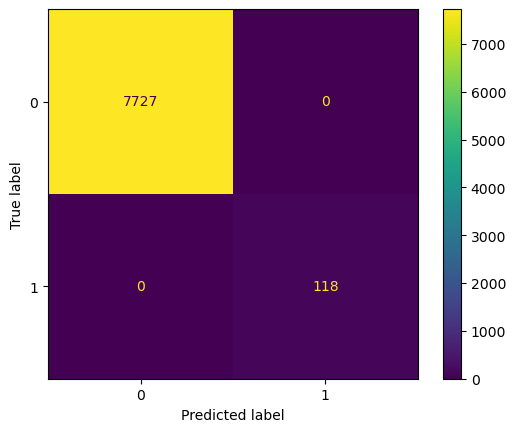

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test,log_reg.predict(X_test))

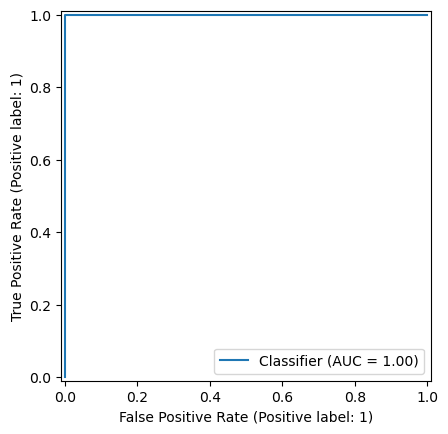

In [59]:
RocCurveDisplay.from_predictions(y_test,log_reg.predict(X_test))

# Retraining model post hyper parameter tuning ( Random forest)

In [60]:
# Hyperparameter tuning for Random Forest (example)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Tuned model training and test data accuracy

In [61]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

best_rf = grid_search.best_estimator_
print("Tuned Random Forest:")
evaluate_model(y_test, best_rf.predict(X_test))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuned Random Forest:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Confusion Matrix:
 [[7727    0]
 [   0  118]]


In [62]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

# Training data accuracy on Tuned random forest model

In [63]:
print("Logistic Regression:")
print(classification_report(y_train,best_rf.predict(X_train)))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30934
           1       1.00      1.00      1.00       442

    accuracy                           1.00     31376
   macro avg       1.00      1.00      1.00     31376
weighted avg       1.00      1.00      1.00     31376



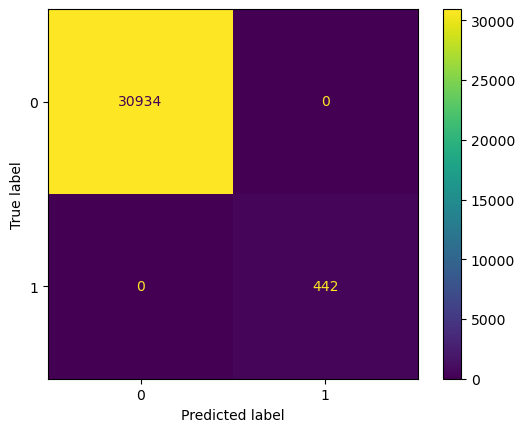

In [64]:
ConfusionMatrixDisplay.from_predictions(y_train,best_rf.predict(X_train))

# Testing data accuracy on Tuned random forest model

In [65]:
print("Logistic Regression:")
print(classification_report(y_test,best_rf.predict(X_test)))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7727
           1       1.00      1.00      1.00       118

    accuracy                           1.00      7845
   macro avg       1.00      1.00      1.00      7845
weighted avg       1.00      1.00      1.00      7845



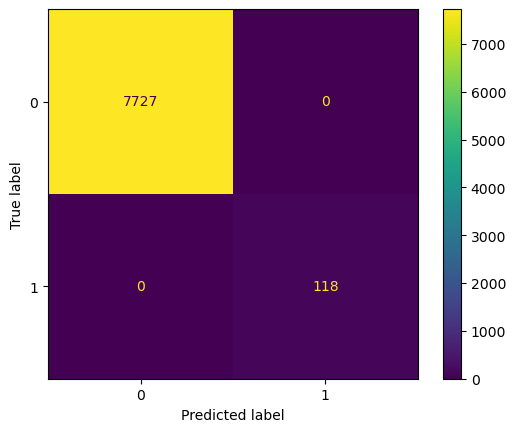

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test,best_rf.predict(X_test))

In [67]:
# Model interpretation
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances)

accountAgeDays              0.786078
isWeekend                   0.101557
paymentMethodAgeDays        0.071965
HighFraudNumItems           0.014928
numItems                    0.013987
localTime                   0.009770
paymentMethod_storecredit   0.001027
Category_shopping           0.000310
paymentMethod_paypal        0.000230
Category_food               0.000148
dtype: float64


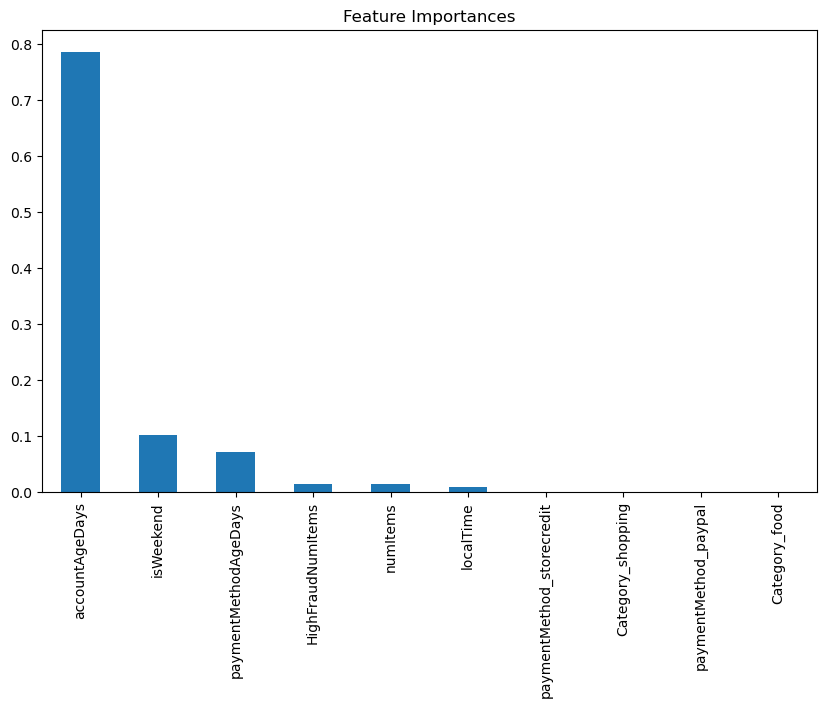

In [68]:
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [69]:
# Model deployment
import joblib
joblib.dump(best_rf, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

# Fitting all models at once (Comparative)

In [70]:
# fit all the models at once
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
clfs = {
    'Logreg' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'XgBoost' : XGBClassifier(),
}

models_report = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'roc auc', 'f1 score'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    print('Fitting model...', clf_name)
    t = {'model name' : clf_name,
        'accuracy' : accuracy_score(y_test, y_pred),
        'recall' : recall_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred),
        'roc auc' : roc_auc_score(y_test, y_pred),
        'f1 score' : f1_score(y_test, y_pred),
        }
    models_report = models_report.append(t, ignore_index=True)

models_report = models_report.sort_values(by='f1 score', ascending=False)
models_report

Fitting model... Logreg
Fitting model... KNN
Fitting model... Naive Bayes
Fitting model... Decision Tree
Fitting model... Random Forest
Fitting model... Gradient Boost
Fitting model... XgBoost


,model name,accuracy,recall,precision,roc auc,f1 score
0,Logreg,1.000000,1.000000,1.000000,1.000000,1.000000
3,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
4,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
5,Gradient Boost,1.000000,1.000000,1.000000,1.000000,1.000000
6,XgBoost,1.000000,1.000000,1.000000,1.000000,1.000000
1,KNN,0.999873,1.000000,0.991597,0.999935,0.995781
2,Naive Bayes,0.999873,0.991525,1.000000,0.995763,0.995745
